In [20]:
import torch
from src.data_loader import FairFaceData, CelebData
from facenet_pytorch import InceptionResnetV1
import torch.utils.data as torchdata
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt



# Sample Mode


In [ ]:
sample = False # sample mode

# Random Validation Data

In [21]:

ffdata = FairFaceData(root = '.', sample = sample)
male_ffdata = ffdata.filter_dataset({'gender': 'Male'})
female_ffdata = ffdata.filter_dataset({'gender': 'Female'})

In [22]:
# if sample mode, use all data:
if sample:
    female_data = female_ffdata
    male_data = male_ffdata
else:
    # retrieve about 5% of data randomly as validation
    _, female_data = torchdata.random_split(female_ffdata, [int(.95 * len(female_ffdata)), len(female_ffdata) - int(.95 * len(female_ffdata))])
    _, male_data = torchdata.random_split(male_ffdata, [int(.95 * len(male_ffdata)), len(male_ffdata) - int(.95 * len(male_ffdata))])

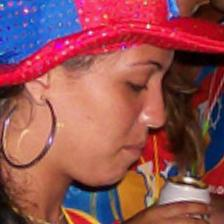

In [23]:
to_pil_image(female_data[0][0])

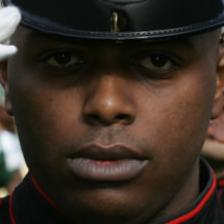

In [24]:
to_pil_image(male_data[0][0])

In [25]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device} for inference')

Using cuda for inference


# ResNet for Fair Face Data (no ethnicity split)

In [26]:
# load model 1 trained on vggface2
model1 = InceptionResnetV1(pretrained = 'vggface2', device = device, classify=False)
_ = model1.eval()

In [27]:
# create dataloader
female_loader = torchdata.DataLoader(female_data, batch_size = 128, shuffle = False )
male_loader = torchdata.DataLoader(male_data, batch_size = 128, shuffle = False )

In [28]:
def compute_euclidean(model, dataloader, device):
    model.to(device)
    model.eval()

    with torch.no_grad():
        d = enumerate(dataloader)
        idx, (img, gender)  = next(d)
        img = img.float().to(device)
        # outputs logit tensors.
        total = model(img)
        # iterate through all images and compute a euclidian
        for idx, (img, gender) in d:
        
            # move img as float and to device
            img = img.float().to(device)
            
            # outputs logit tensors.
            t = model(img)
            # combine with current total
            total = torch.vstack([total, t])
        
        #centroid = total.mean(dim = 0)
        #distances = ((total - centroid) ** 2).sum(dim = 1) # compute euclidean distance
        
    return total #distances

In [29]:
male_totals = compute_euclidean(model1, male_loader, device = device)
female_totals = compute_euclidean(model1, female_loader, device = device)


In [30]:
male_centroid = male_totals.mean(dim = 0)
male_centroid.shape

torch.Size([512])

In [31]:
male_male_euclidian = ((male_totals - male_centroid) ** 2).sum(dim = 1) # euclidian for males
female_male_euclidian = ((female_totals - male_centroid) ** 2).sum(dim = 1) # euclidian for males

Text(0, 0.5, 'Count')

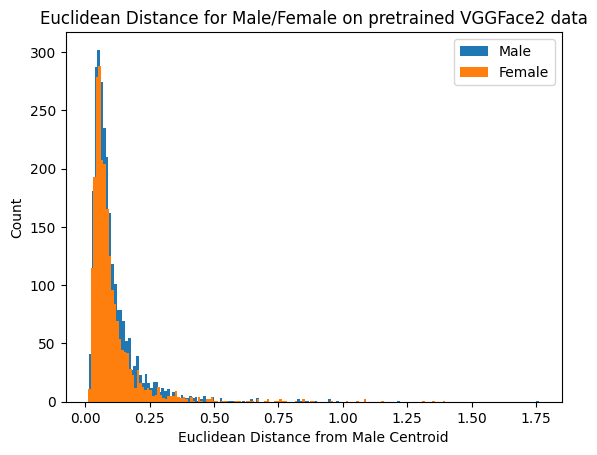

In [32]:
_ = plt.hist(male_male_euclidian.cpu().detach().numpy(), label = 'Male', bins = 'auto')
_ = plt.hist(female_male_euclidian.cpu().detach().numpy(), label = 'Female', bins = 'auto')
_ = plt.legend()
plt.title('Euclidean Distance for Male/Female on pretrained VGGFace2 data')
plt.xlabel('Euclidean Distance from Male Centroid')
plt.ylabel('Count')

# ResNet using Casia-webface

In [33]:
# load model 1 trained on vggface2
model2 = InceptionResnetV1(pretrained = 'casia-webface', device = device, classify=False)
_ = model2.eval()

In [34]:
male_totals = compute_euclidean(model2, male_loader, device = device)
female_totals = compute_euclidean(model2, female_loader, device = device)


In [35]:
male_centroid = male_totals.mean(dim = 0)
male_centroid.shape

torch.Size([512])

In [36]:
male_male_euclidian = ((male_totals - male_centroid) ** 2).sum(dim = 1) # euclidian for males
female_male_euclidian = ((female_totals - male_centroid) ** 2).sum(dim = 1) # euclidian for males

Text(0, 0.5, 'Count')

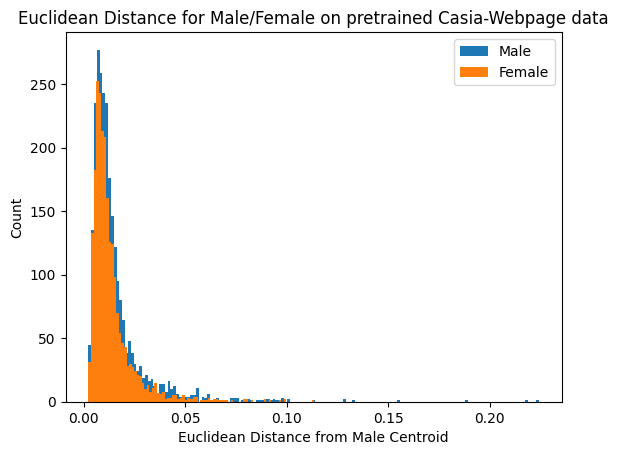

In [37]:
_ = plt.hist(male_male_euclidian.cpu().detach().numpy(), label = 'Male', bins = 'auto')
_ = plt.hist(female_male_euclidian.cpu().detach().numpy(), label = 'Female', bins = 'auto')
_ = plt.legend()
plt.title('Euclidean Distance for Male/Female on pretrained Casia-Webpage data')
plt.xlabel('Euclidean Distance from Male Centroid')
plt.ylabel('Count')